In [57]:
# machine learning module
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# ANN module
import torch
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv('bank_marketing.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# PART II - Preprocessing

### 모든 데이터의 인코딩 및 데이터 전처리

In [59]:
# 출력변수 '정기예금' 'y'의 인코딩
df.y.replace({'no': 0, 'yes': 1}, inplace = True)

In [60]:
# 입력변수 'month'의 인코딩
df.month.replace({'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr' : 4, 'may' : 5, 'jun' : 6, 
                  'jul' : 7, 'aug' : 8, 'sep' : 9, 'oct' : 10, 'nov' : 11, 'dec' : 12}, inplace = True)

# 입력변수 'default'의 인코딩
df.default.replace({'no' : 0, 'yes' : 1}, inplace = True)

# 입력변수 'housing'의 인코딩
df.housing.replace({'no' : 0, 'yes' : 1}, inplace = True)

# 입력변수 'loan'의 인코딩
df.loan.replace({'no' : 0, 'yes' : 1}, inplace = True)

# 입력변수 'marital'의 인코딩
marital_dummies = pd.get_dummies(df['marital'], prefix = 'marital')
marital_dummies.drop('marital_divorced', axis=1, inplace=True)
df = pd.concat([df, marital_dummies], axis=1)

# 입력변수 'job의 인코딩
job_dummies = pd.get_dummies(df['job'], prefix = 'job')
job_dummies.drop('job_unknown', axis=1, inplace=True)
df= pd.concat([df, job_dummies], axis=1)

# 입력변수 'education'의 인코딩
education_dummies = pd.get_dummies(df['education'], prefix = 'education')
education_dummies.drop('education_unknown', axis=1, inplace=True)
df = pd.concat([df, education_dummies], axis=1)

# 입력변수 'contact'의 인코딩
contact_dummies = pd.get_dummies(df['contact'], prefix = 'contact')
contact_dummies.drop('contact_unknown', axis=1, inplace=True)
df = pd.concat([df, contact_dummies], axis=1)

# 입력변수 'poutcome'의 인코딩
poutcome_dummies = pd.get_dummies(df['poutcome'], prefix = 'poutcome')
poutcome_dummies.drop('poutcome_unknown', axis=1, inplace=True)
df = pd.concat([df, poutcome_dummies], axis=1)

# 입력변수 'pdays'의 인코딩
df['pdays'] = df['pdays'].apply(lambda row: 0 if row == -1 else 1)

In [61]:
# 카테고리 데이터인'marital','job', 'education', 'contact', 'poutcome'열을 삭제하고 수치 데이터만 남기게 만들어준다.
df.drop(['marital', 'job', 'education', 'contact', 'poutcome'], axis=1,inplace=True)

In [62]:
df.dtypes

age                    int64
default                int64
balance                int64
housing                int64
loan                   int64
day                    int64
month                  int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                      int64
marital_married        uint8
marital_single         uint8
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
contact_cellular       uint8
contact_telephone      uint8
poutcome_failure       uint8
poutcome_other         uint8
poutcome_success       uint8
dtype: object

In [63]:
display(df)

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,job_technician,job_unemployed,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success
0,58,0,2143,1,0,5,5,261,1,0,...,0,0,0,0,1,0,0,0,0,0
1,44,0,29,1,0,5,5,151,1,0,...,1,0,0,1,0,0,0,0,0,0
2,33,0,2,1,1,5,5,76,1,0,...,0,0,0,1,0,0,0,0,0,0
3,47,0,1506,1,0,5,5,92,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,5,5,198,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,11,977,3,0,...,1,0,0,0,1,1,0,0,0,0
45207,71,0,1729,0,0,17,11,456,2,0,...,0,0,1,0,0,1,0,0,0,0
45208,72,0,5715,0,0,17,11,1127,5,1,...,0,0,0,1,0,1,0,0,0,1
45209,57,0,668,0,0,17,11,508,4,0,...,0,0,0,1,0,0,1,0,0,0


In [64]:
# 인코딩 후의 데이터 세트 저장
df.to_csv('bank_marketing_dataset.csv', index=False)

# PART V - Deep learning

In [65]:
# Train and Test dataset
X = df.drop('y', axis=1)  # 데이터프레임에서 타겟값(y)을 제외
y = df['y']               # 타겟값(y) 추출

In [66]:
print(type(X))   # DataFrame type
print(type(y))   # Series type

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [67]:
X = X.to_numpy() # 데이터프레임에서 타겟값(y)을 제외하고 넘파이 배열로 만들기
y = y.to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기
print(type(X))   # Numpy Array
print(type(y))   # Numpy Array

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [68]:
# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(y)
y = scaler.transform(y)

In [69]:
#X = X.to(device, dtype=torch.float64)
#y = y.to(device, dtype=torch.float64)
#X = X.cuda()
#y = y.cuda()


In [70]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        # GPU 사용 시 활성화
        self.x_data = self.x_data.cuda()
        self.y_data = self.y_data.cuda()
        
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [71]:
# dataset 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36168, 32), (9043, 32), (36168, 1), (9043, 1))

In [73]:
print("The shape of X_train: ", X_train.shape)
print("The shape of X_test: ", X_test.shape)
print("The shape of y_train: ", y_train.shape)
print("The shape of y_test: ", y_test.shape)

The shape of X_train:  (36168, 32)
The shape of X_test:  (9043, 32)
The shape of y_train:  (36168, 1)
The shape of y_test:  (9043, 1)


In [74]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [75]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(32, 64, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(64, 32, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(32, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [76]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [77]:
print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system?True
CUDA version: 11.7
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 3090


In [78]:
# GPU 사용할 경우 아래 코드를 활성화
print(cuda_id)
model = model.to(cuda_id)

0


In [79]:
# 병렬 GPU 사용할 경우 아래 코드를 활성화
# model = nn.DataParallel(model, device_ids = [0,1])   # 4개의 GPU를 이용할 경우
# model.cuda()

In [80]:
loss_ = [] # loss를 저장할 리스트.
acc_ = [] # acc를 저장할 리스트.
n = len(trainloader)
num_epochs = 50
print(n)
print(len(trainsets))

for epoch in range(num_epochs):

    running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.
    correct = 0
    for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    
        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화.

        outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
        loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
        loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
        optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.    
        correct += (outputs == values).float().sum()

    accuracy = 100 * correct / len(trainsets)

    #print("Accuracy = {},".format(accuracy))

    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, running_loss/n, accuracy))
    loss_.append(running_loss) # MSE(Mean Squared Error) 계산
    acc_.append(accuracy)

1131
36168
Epoch 1/50, Loss: 0.118, Accuracy: 88.235
Epoch 2/50, Loss: 0.118, Accuracy: 88.235
Epoch 3/50, Loss: 0.118, Accuracy: 88.235
Epoch 4/50, Loss: 0.118, Accuracy: 88.235
Epoch 5/50, Loss: 0.118, Accuracy: 88.235
Epoch 6/50, Loss: 0.118, Accuracy: 88.235
Epoch 7/50, Loss: 0.118, Accuracy: 88.235
Epoch 8/50, Loss: 0.105, Accuracy: 8.422
Epoch 9/50, Loss: 0.104, Accuracy: 0.000
Epoch 10/50, Loss: 0.104, Accuracy: 0.000
Epoch 11/50, Loss: 0.104, Accuracy: 0.000
Epoch 12/50, Loss: 0.104, Accuracy: 0.000
Epoch 13/50, Loss: 0.104, Accuracy: 0.000
Epoch 14/50, Loss: 0.104, Accuracy: 0.000
Epoch 15/50, Loss: 0.104, Accuracy: 0.000
Epoch 16/50, Loss: 0.104, Accuracy: 0.000


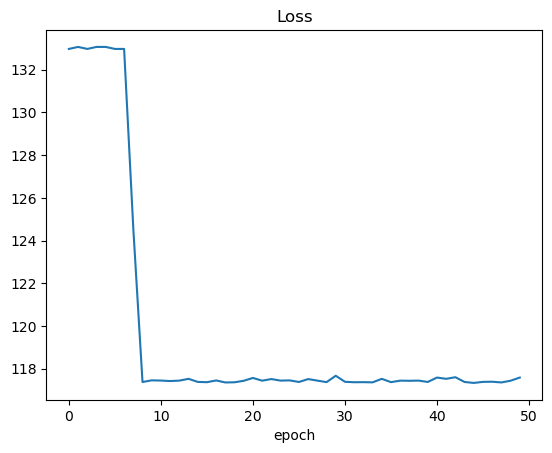

In [ ]:
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def evaluation(dataloader):

  # predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  # actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.
  # GPU를 사용할 경우 아래 코드로 실행
  predictions = torch.tensor([], dtype=torch.float).cuda() # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float).cuda() # 실제값을 저장하는 텐서.
  

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  # predictions = predictions.numpy() # 넘파이 배열로 변경.  
  # actual = actual.numpy() # 넘파이 배열로 변경.
  # GPU를 사용할 경우 아래 코드로 실행
  predictions = predictions.cpu().numpy() # 넘파이 배열로 변경.
  actual = actual.cpu().numpy() # 넘파이 배열로 변경.
  
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

In [ ]:
train_rmse = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
test_rmse = evaluation(testloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:0.32219821214675903
test rmse:0.3182276785373688


In [ ]:
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)